In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
import gym
from gym import spaces
import numpy as np

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

In [4]:
# Load the dataset
df = pd.read_csv('monthly-beer-production-in-austr.csv')

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
production = df['Monthly beer production'].values.reshape(-1, 1)

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
production_scaled = scaler.fit_transform(production)

In [7]:
# Assuming `production_scaled` is  normalized dataset
total_samples = len(production_scaled)
test_size = 24  # using last 12 months as the test set
sequence_length = 12
 # Include sequence_length to build the first sequence

In [8]:
# Split the data into training and test sets
train_data = production_scaled[:total_samples - test_size]
test_data = production_scaled[total_samples - test_size :] 

In [9]:
# Unforeseen sequence: the last `sequence_length` months from the original dataset
unforeseen_sequence = production_scaled[-sequence_length:].reshape(1, sequence_length, 1)  # Reshape for the model

In [10]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 12  # Use 12 months of data to predict the next month

# Create training and test sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming X_train, y_train, X_test, and y_test are numpy arrays from your code.
# Convert them to PyTorch tensors and move to the correct device (CPU or GPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.linear(out[:, -1, :]) 
        return out

# Set the random seed for reproducibility
torch.manual_seed(0)

# Hyperparameters
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100

# Create the LSTM model instance
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    # Reshape outputs and y_train_tensor to match shapes
    outputs = outputs.view(-1)
    y_train_tensor = y_train_tensor.view(-1)
    
    # Compute the loss
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')


Epoch 0/100, Loss: 0.3262944519519806
Epoch 10/100, Loss: 0.03160481154918671
Epoch 20/100, Loss: 0.024354180321097374
Epoch 30/100, Loss: 0.017542721703648567
Epoch 40/100, Loss: 0.016550058498978615
Epoch 50/100, Loss: 0.015347854234278202
Epoch 60/100, Loss: 0.0145247308537364
Epoch 70/100, Loss: 0.01312961895018816
Epoch 80/100, Loss: 0.011565525084733963
Epoch 90/100, Loss: 0.014243140816688538


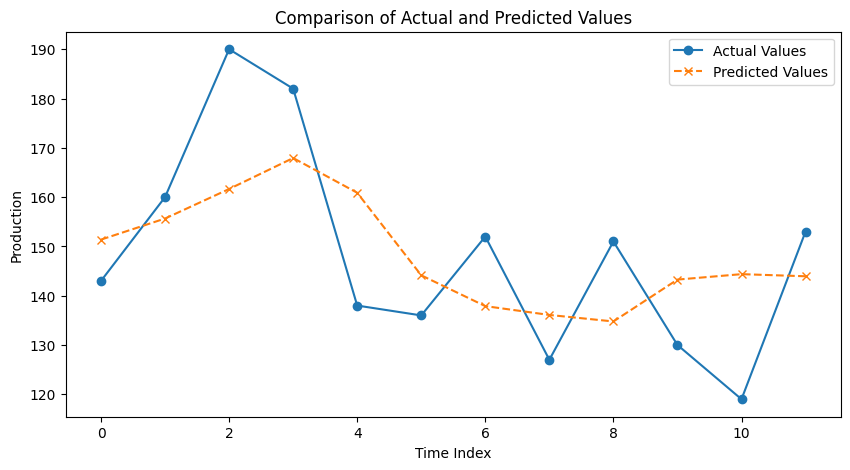

In [12]:
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Convert test set to tensor
X_test_tensor = torch.tensor(X_test).float().to(device)

# Perform inference
with torch.no_grad():  # We don't need to compute gradients for inference
    test_predictions = model(X_test_tensor)
    test_predictions = test_predictions.view(-1).cpu().numpy()  # Reshape and move back to CPU

# Inverse transform the predictions to the original scale
test_predictions_inverse = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Here y_test is expected to be in the same format as the output from create_sequences function
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Compare the predictions with actual values (Optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse, label='Actual Values', marker='o')
plt.plot(test_predictions_inverse, label='Predicted Values', marker='x', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Index')
plt.ylabel('Production')
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 0.10552467415737746
Mean Absolute Error (MAE): 0.09439237800493737
